In [1]:
from model import encoder, decoder
from util import datasets
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from train import train
from model import encoder, decoder
import os
import cv2
import loss
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
PARAM_CHAIRS = {
    'train': '/home/anatolios/project/All_in_one/FlyingChairs/',
    'test': '/home/julia0607/Flying Chairs/testing',
    'name': 'FlyingChairs',
    'dtype': 'image'
}
BATCH_SIZE = 10
N_EPOCHS = 30
LR = 1e-4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def prepare_data(param, transformation):
    """
    Return dataloader of given parameters
    """
    # Extract parameters
    path_train, path_test, name, dtype = param['train'], param['test'], param['name'], param['dtype']
    
    # Create dataset for train and test path
    data_train = datasets.Datasets(path_train, name, dtype, transforms=transformation, img_size=224)
#     print(data_train[0][1].shape)
#     data_test = datasets.Datasets(path_test, name, dtype, transforms=transformation)

    # Create dataloader for train and test
#     dataloader_train = DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
#     dataloader_test = DataLoader(dataset=data_test, batch_size=BATCH_SIZE, shuffle=True)
    return data_train, data_train

In [4]:
trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
fc_train, _ = prepare_data(PARAM_CHAIRS, trans)

In [5]:
def imshow(img):
    """
    Show image from normalized tensor data
    """
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

In [6]:
img = fc_train[0][0]
imshow(img)

array([[[0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        ...,
        [0.06666665, 0.02745099, 0.02745099],
        [0.06666665, 0.02745099, 0.02745099],
        [0.06666665, 0.02745099, 0.02745099]],

       [[0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        ...,
        [0.06666665, 0.02745099, 0.02745099],
        [0.06666665, 0.02745099, 0.02745099],
        [0.06666665, 0.02745099, 0.02745099]],

       [[0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        [0.04705882, 0.02352943, 0.02745099],
        ...,
        [0.07058822, 0.03137255, 0.03137254],
        [0.07058822, 0.03137255, 0.03137254],
        [0.07058822, 0.03137255, 0.03137254]],

       ...,

       [[0.00784314, 0.08627453, 0.08235294],
        [0.22745095, 0.28235295, 0.28235297],
        [0.04313724, 0

In [7]:
def flow2RGB(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3)).astype('uint8')
    hsv[...,1] = 255
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang * 180 / np.pi / 2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)[:, :, ::-1]
    return rgb

def flowshow(flow):
    """
    Visualize optical flow
    """
    flow = flow.numpy().transpose((1, 2, 0))
    # Reverse normalize
    flow[..., 0] = flow[..., 0] * flow.shape[1]
    flow[..., 1] = flow[..., 1] * flow.shape[0]

    rgb = flow2RGB(flow)
    return rgb

In [8]:
flowshow(fc_train[0][1])

array([[[13,  0, 15],
        [13,  0, 15],
        [13,  0, 15],
        ...,
        [ 7,  0,  2],
        [ 7,  0,  2],
        [ 7,  0,  2]],

       [[13,  0, 15],
        [13,  0, 15],
        [13,  0, 15],
        ...,
        [ 7,  0,  2],
        [ 7,  0,  2],
        [ 7,  0,  2]],

       [[13,  0, 15],
        [13,  0, 15],
        [13,  0, 15],
        ...,
        [ 7,  0,  2],
        [ 7,  0,  2],
        [ 7,  0,  2]],

       ...,

       [[ 3,  0, 13],
        [ 3,  0, 13],
        [ 3,  0, 13],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]],

       [[ 3,  0, 13],
        [ 3,  0, 13],
        [ 3,  0, 13],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]],

       [[ 3,  0, 13],
        [ 3,  0, 13],
        [ 3,  0, 13],
        ...,
        [ 0,  1,  1],
        [ 0,  1,  1],
        [ 0,  1,  1]]], dtype=uint8)

In [9]:
def combine_plot(img, flow, flow_recon, idx, save_path):
    img_p = imshow(img)
    flow_p = flowshow(flow)
    flow_recon_p = flowshow(flow_recon)
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(img_p)
    axs[0].set_title('Image')
    axs[1].imshow(flow_p)
    axs[1].set_title('GT')
    axs[2].imshow(flow_recon_p)
    axs[2].set_title('Prediction')
    fig.savefig(os.path.join(save_path, '{}.jpg'.format(idx)), dpi=150)
    plt.close(fig)

In [10]:
model = {
    'encoder' : encoder(vae = False),
    'decoder' : decoder()
}
model['encoder'].load_state_dict(torch.load('saved/0801_second/weight_encoder.pt'))
model['decoder'].load_state_dict(torch.load('saved/0801_second/weight_decoder.pt'))
print('best weight loaded!')

best weight loaded!


In [11]:
SAVE_PATH = 'saved/0801_second/results'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
for i in range(15):
    idx = np.random.randint(len(fc_train))
    img, flow = fc_train[idx]
    img, flow = img.unsqueeze(0), flow.unsqueeze(0)
    with torch.no_grad():
        model['encoder'].eval()
        model['decoder'].eval()
        z = model['encoder'](flow, img)
        flow_recon = model['decoder'](z, img)
    combine_plot(img.squeeze(), flow.squeeze(), flow_recon.squeeze(), i, SAVE_PATH)

torch.Size([1, 2, 224, 224])

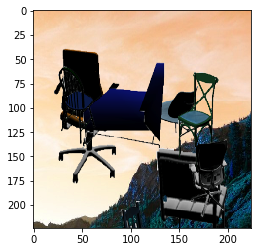

In [12]:
imshow(img.squeeze())

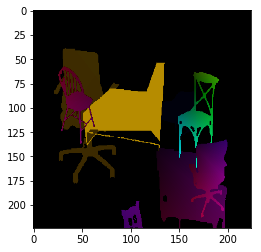

In [13]:
flowshow(flow.squeeze())

torch.Size([1, 2, 224, 224])


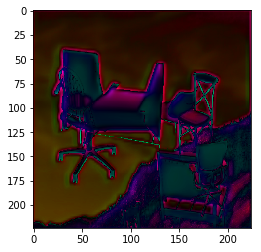

In [14]:
print(flow_recon.shape)
flowshow(flow_recon.squeeze())

In [111]:
flow_recon[0, 1, ...]

tensor([[ 9.4991e-01,  1.1864e+00,  1.4348e+00,  ...,  2.2063e-01,
          3.5680e-02,  9.6990e-03],
        [ 9.1465e-01,  1.1609e+00,  1.4190e+00,  ...,  3.0544e-01,
          2.4370e-01,  6.1492e-02],
        [ 8.7939e-01,  1.1354e+00,  1.4033e+00,  ...,  4.5870e-01,
          2.6490e-01,  2.0064e-01],
        ...,
        [-5.0882e-01, -4.7673e-01, -3.7326e-01,  ..., -5.7224e-01,
         -4.2356e-01, -3.8337e-01],
        [-4.5146e-01, -5.3913e-01, -3.3863e-01,  ..., -4.8808e-01,
         -3.4247e-01, -2.6907e-01],
        [-4.3690e-01, -5.5112e-01, -3.8597e-01,  ..., -3.0266e-01,
         -2.3988e-01, -1.3233e-01]])